# Implementation of Open Set Recognition (OSR)

     * VAE-GAN - Images generated by a VAE and a DCGAN. 
          - First row: samples from a VAE
          - Second row: samples from a DCGAN 
     * LR - Liklihood Regret(OOD DETECTION)
     * CNN - Classification Problem(OSR Classification)

In [ ]:
# clone the github repository to access source code
!git clone https://github.com/AvihaiNaa/gmdl_final.git

# set the correct directory
%cd gmdl_final

Cloning into 'gmdl_final'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 1), reused 18 (delta 1), pack-reused 0
Unpacking objects: 100% (18/18), done.
/content/gmdl_final/gmdl_final


##### Imports

In [ ]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch.nn.functional as F
import gmdl_final.utils as utils
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import torch.optim as optim
from torch.autograd import Variable
import os
import copy

### Config

In [ ]:
dataset_path = './datasets'
config = {
    "batch_size": 100,
    "device": "cuda",
    "learning_rate": 0.001,
    "num_epochs": 30,#30,
    "split_dataset": 0.8,
    "cnn_path":"cnn_models.pt",
    "h-dvae_path":"hdvae_models.pt",
    #"image_size": (28, 28)
    "image_size": (32, 32),
    "experiment": 'models/mnist'
}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

###    Step 1. Load (or download) Dataset
     * Added Data Augmentation


In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(config["image_size"]),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomRotation(50),
        #AddGaussianNoise(0.1, 0.08),
        transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
        transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.5, 1))
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=config["batch_size"], shuffle=False, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
imgs, _ = next(iter(train_loader))


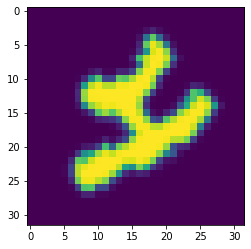

In [ ]:
utils.show_image(imgs, idx = 71)

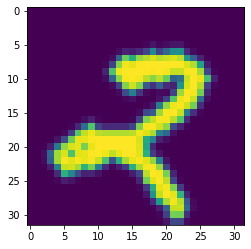

In [ ]:
utils.show_image(imgs, idx = 15)

### Step 2. Define our model: (VAE) Variational AutoEncoder  - (DCGAN) Deep Convolutional Generative Adversarial Network

    *Network structure for VAE based on DCGAN

In [ ]:
import gmdl_final.model as DVAE


In [ ]:
config_model ={
    "beta-vae": 1.,
    "beta-adam": 0.9,
    "number_gpu": 1,
    "latent_z_vector": 100,
    "input_image_channels": 1,
    "hidden_channel_size": 32,
    #"image_size": 28,
    "image_size": 32,
    "learning_rate": 3e-4,
    "learning_rate_regret": 2e-4,
    "epochs": 50,
    "perturbed": False,
    "ratio": 0.2,
    "dataroot": './data',
    "repeat":100,
    "num_iter_samples": 100    
}

### Step 3. Define Loss function (reprod. loss) and optimizer

In [ ]:
def loss_function(x_src, recon, target, mean, log_var):
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    b = x_src.size(0)
    recl = loss_fn(recon, target)
    recl = torch.sum(recl) / b
    kld = KL_div(mean, log_var)
    return recl + config_model["beta-vae"] * kld.mean(), recl, kld


def KL_div(mu, logvar, reduction='avg'):
    mu = mu.view(mu.size(0), mu.size(1))
    logvar = logvar.view(logvar.size(0), logvar.size(1))
    if reduction == 'sum':
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    else:
        KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1)
        return KL

### Pre-Train

In [ ]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  6084


### Step 4. Train VAE-DCGAN
    * Init model weights
    * Init optimizer
    * Train model


In [ ]:
netG = DVAE.DCGAN_G(config_model["image_size"], config_model["latent_z_vector"], config_model["input_image_channels"],config_model["hidden_channel_size"],  config_model["number_gpu"])
netG.apply(utils.weights_init)
netE = DVAE.Encoder(config_model["image_size"], config_model["latent_z_vector"], config_model["input_image_channels"],config_model["hidden_channel_size"],  config_model["number_gpu"])
netE.apply(utils.weights_init)
netE.to(device)
netG.to(device)

DCGAN_G(
  (main): Sequential(
    (initial:100-128:convt): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (initial:128:relu): ReLU(inplace=True)
    (pyramid:128-64:convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:64:batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:64:relu): ReLU(inplace=True)
    (pyramid:64-32:convt): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:32:batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:32:relu): ReLU(inplace=True)
    (final:32-1:convt): ConvTranspose2d(32, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [ ]:
# setup optimizer
optimizer1 = optim.Adam(netE.parameters(), lr=config_model["learning_rate"], weight_decay=3e-5)
optimizer2 = optim.Adam(netG.parameters(), lr=config_model["learning_rate"], weight_decay=3e-5)

In [ ]:
netE.train()
netG.train()

DCGAN_G(
  (main): Sequential(
    (initial:100-128:convt): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (initial:128:relu): ReLU(inplace=True)
    (pyramid:128-64:convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:64:batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:64:relu): ReLU(inplace=True)
    (pyramid:64-32:convt): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:32:batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:32:relu): ReLU(inplace=True)
    (final:32-1:convt): ConvTranspose2d(32, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [ ]:
rec_l = []
kl = []
tloss = []
for epoch in range(config_model["epochs"]):
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)
        if config_model["perturbed"]:
            x = utils.perturb(x, config_model["ratio"], device)
        target = Variable(x.data.view(-1) * 255).long()
        [z, mu, logvar] = netE(x)
        recon = netG(z)
        recon = recon.contiguous()
        recon = recon.view(-1, 256)
        loss, recl, kld = loss_function(x, recon, target, mu, logvar)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        total_loss = loss
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        rec_l.append(recl.detach().item())
        kl.append(kld.mean().detach().item())
        tloss.append(loss.detach().item())
        if not i % 100:
            print('epoch:{} recon:{} kl:{}'.format(epoch, np.mean(rec_l), np.mean(kl)))

epoch:0 recon:5677.35498046875 kl:32.013309478759766
epoch:0 recon:4398.636479443843 kl:16.73746100982817
epoch:0 recon:3681.307017160292 kl:26.848160404471024
epoch:0 recon:3323.381430388289 kl:33.28423434000871
epoch:0 recon:3104.8906858829487 kl:37.73174275781151
epoch:0 recon:2953.5665227162863 kl:40.92057610224345
epoch:1 recon:2841.8284719152975 kl:43.56879448771675
epoch:1 recon:2752.2224897746523 kl:45.6621090178823
epoch:1 recon:2681.516410760963 kl:47.392009694031564
epoch:1 recon:2623.1326529008566 kl:48.84573165849099
epoch:1 recon:2575.4701389918673 kl:50.06558758919532
epoch:1 recon:2534.3278716569807 kl:51.05921064778743
epoch:2 recon:2497.127369343093 kl:51.94880233299325
epoch:2 recon:2464.8293034804956 kl:52.70886560149783
epoch:2 recon:2436.919646541533 kl:53.440592176653844
epoch:2 recon:2413.389047845056 kl:54.143111911636446
epoch:2 recon:2390.43883553004 kl:54.708940634349226
epoch:2 recon:2369.7633878336733 kl:55.20383496960074
epoch:3 recon:2351.3794924721724 k

#### Save Model

In [ ]:
current_directory = os.getcwd()
current_directory = os.path.join(current_directory, r'saved_models')
if not os.path.exists(current_directory):
    os.makedirs(current_directory)
current_directory = os.path.join(current_directory, config["experiment"])
if not os.path.exists(current_directory):
    os.makedirs(current_directory)# os.mkdir('./saved_models'+ opt.experiment)
torch.save(netG.state_dict(), './saved_models/{}/netG_pixel.pth'.format(config["experiment"], config_model["hidden_channel_size"]))
torch.save(netE.state_dict(), './saved_models/{}/netE_pixel.pth'.format(config["experiment"], config_model["hidden_channel_size"]))

### Load Datasets - Test step

##### Load Models

In [ ]:
print('Building models...')
netG = DVAE.DCGAN_G(config_model["image_size"], config_model["latent_z_vector"], config_model["input_image_channels"],config_model["hidden_channel_size"],  config_model["number_gpu"])
state_G = torch.load('./saved_models/models/mnist/netG_pixel.pth', map_location = device)
netG.load_state_dict(state_G)
netG.to(device)

netE = DVAE.Encoder(config_model["image_size"], config_model["latent_z_vector"], config_model["input_image_channels"],config_model["hidden_channel_size"],  config_model["number_gpu"])
state_E = torch.load('./saved_models/models/mnist/netE_pixel.pth', map_location = device)
netE.load_state_dict(state_E)
netE.to(device)


Building models...


Encoder(
  (conv1): Conv2d(128, 100, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(128, 100, kernel_size=(4, 4), stride=(1, 1))
  (main): Sequential(
    (input-conv): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (input-BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (input-relu): ReLU(inplace=True)
    (pyramid:32-64:conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:64:batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:64:relu): ReLU(inplace=True)
    (pyramid:64-128:conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:128:relu): ReLU(inplace=True)
  )
)

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [ ]:

import gmdl_final.loader as loader
fmnist_data_loader = loader.load_fmnist(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])
cifar_data_loader = loader.load_cifar(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])
svhn_data_loader = loader.load_svhn(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])
emnist_letters_data_loader = loader.load_emnist_letters(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])
mnist_test_data_loader = loader.load_mnist_test(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


  0%|          | 0/64275384 [00:00<?, ?it/s]

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Computing Likelihood Regret (LR)

In [ ]:
netG.eval()
netE.eval()
loss_fn = nn.CrossEntropyLoss(reduction = 'none')

### Likleihood Regret Algorithm

In [ ]:
def likleihood_regret(data_loader, samples, netE, netG):
    NLL_regret_indist = []
    NLL_indist = []

    for i, (xi, _) in enumerate(data_loader):
       
        x = xi.expand(config_model["repeat"],-1,-1,-1).contiguous()
        weights_agg  = []
        with torch.no_grad():
            #NLL ALG.
            for batch_number in range(5):
                
                x = x.to(device)
                b = x.size(0)
        
                [z,mu,logvar] = netE(x)
                recon = netG(z)
                mu = mu.view(mu.size(0),mu.size(1))
                logvar = logvar.view(logvar.size(0), logvar.size(1))
                z = z.view(z.size(0),z.size(1))
                weights = utils.store_NLL(x, recon, mu, logvar, z, config_model["repeat"])
              
                weights_agg.append(weights)
            
            weights_agg = torch.stack(weights_agg).view(-1) 
            
            NLL_loss_before = utils.compute_NLL(weights_agg) 
            NLL_indist = np.append(NLL_indist, NLL_loss_before.detach().cpu().numpy())

            
        #Likelihood Regret ALG.
        xi = xi.to(device)
        b = xi.size(0)
        netE_copy = copy.deepcopy(netE)
        netE_copy.eval()
        optimizer = optim.Adam(netE_copy.parameters(), lr=config_model["learning_rate"], betas=(config_model["beta-adam"], 0.999),weight_decay=5e-5)
        target = Variable(xi.data.view(-1) * 255).long()
        for it in range(config_model["num_iter_samples"]):
            
            [z,mu,logvar] = netE_copy(xi)
            recon = netG(z)
            
            recon = recon.contiguous()
            recon = recon.view(-1,256)
            recl = loss_fn(recon, target)
            
            recl = torch.sum(recl) / b
            kld = KL_div(mu,logvar)
            
            loss =  recl + kld.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        weights_agg  = []
        with torch.no_grad():
            xi = xi.expand(config_model["repeat"],-1,-1,-1).contiguous()
            target = Variable(xi.data.view(-1) * 255).long()
            for batch_number in range(5):
                [z,mu,logvar] = netE_copy(xi)
                recon = netG(z)
                recon = recon.contiguous()
                mu = mu.view(mu.size(0),mu.size(1))
                logvar = logvar.view(logvar.size(0), logvar.size(1))
                z = z.view(z.size(0),z.size(1))
                weights = utils.store_NLL(x, recon, mu, logvar, z, config_model["repeat"])
                
                weights_agg.append(weights)
         
            
            weights_agg = torch.stack(weights_agg).view(-1) 
            NLL_loss_after = utils.compute_NLL(weights_agg) 
            print('In-dist image {} OPT: {} VAE: {} diff:{}'.format(i, NLL_loss_after.item(), NLL_loss_before.item(), NLL_loss_before.item()  - NLL_loss_after.item()))
            regret = NLL_loss_before  - NLL_loss_after
            NLL_regret_indist = np.append(NLL_regret_indist, regret.detach().cpu().numpy())
        if i >= samples: #test for 500 samples
            break
    return NLL_regret_indist, NLL_indist

### Compute Likelihood Regret VS NLL - In Distribution(MNIST)

In [ ]:
samples = 299

In [ ]:
NLL_regret_indist, NLL_indist = likleihood_regret(mnist_test_data_loader, samples, netE, netG)

In-dist image 0 OPT: 630.8939208984375 VAE: 663.3642578125 diff:32.4703369140625
In-dist image 1 OPT: 668.0514526367188 VAE: 698.5006103515625 diff:30.44915771484375
In-dist image 2 OPT: 637.9470825195312 VAE: 649.933349609375 diff:11.98626708984375
In-dist image 3 OPT: 654.666015625 VAE: 672.4020385742188 diff:17.73602294921875
In-dist image 4 OPT: 574.1522827148438 VAE: 624.3987426757812 diff:50.2464599609375
In-dist image 5 OPT: 660.1686401367188 VAE: 688.3626098632812 diff:28.1939697265625
In-dist image 6 OPT: 626.7936401367188 VAE: 643.8450317382812 diff:17.0513916015625
In-dist image 7 OPT: 646.7097778320312 VAE: 663.0609741210938 diff:16.3511962890625
In-dist image 8 OPT: 644.5147094726562 VAE: 698.6309814453125 diff:54.11627197265625
In-dist image 9 OPT: 602.9508666992188 VAE: 625.66259765625 diff:22.71173095703125
In-dist image 10 OPT: 691.6239013671875 VAE: 695.9757080078125 diff:4.351806640625
In-dist image 11 OPT: 578.6361083984375 VAE: 628.03125 diff:49.3951416015625
In-di

In [ ]:
current_directory = os.getcwd()
current_directory = os.path.join(current_directory, r'array')
if not os.path.exists(current_directory):
    os.makedirs(current_directory)
np.save('./array/indist_nll.npy', NLL_indist)
np.save('./array/indist_regret.npy', NLL_regret_indist)

### Compute Likelihood Regret VS NLL - Out Of Distribution(FMNIST)

In [ ]:
NLL_regret_ood_fash, NLL_ood_fash = likleihood_regret(fmnist_data_loader, samples, netE, netG)

In-dist image 0 OPT: 1459.166259765625 VAE: 1841.6826171875 diff:382.516357421875
In-dist image 1 OPT: 1573.2197265625 VAE: 1799.99462890625 diff:226.77490234375
In-dist image 2 OPT: 1848.091552734375 VAE: 1893.76806640625 diff:45.676513671875
In-dist image 3 OPT: 1121.89208984375 VAE: 1289.39794921875 diff:167.505859375
In-dist image 4 OPT: 1552.9896240234375 VAE: 1819.212646484375 diff:266.2230224609375
In-dist image 5 OPT: 1541.0718994140625 VAE: 1777.439208984375 diff:236.3673095703125
In-dist image 6 OPT: 1170.5985107421875 VAE: 1463.8336181640625 diff:293.235107421875
In-dist image 7 OPT: 1225.0291748046875 VAE: 1392.7835693359375 diff:167.75439453125
In-dist image 8 OPT: 1431.043701171875 VAE: 1804.74658203125 diff:373.702880859375
In-dist image 9 OPT: 1368.5748291015625 VAE: 1588.9359130859375 diff:220.361083984375
In-dist image 10 OPT: 1462.544189453125 VAE: 1881.6907958984375 diff:419.1466064453125
In-dist image 11 OPT: 1417.9608154296875 VAE: 1584.0882568359375 diff:166.1274

In [ ]:
current_directory = os.getcwd()
current_directory = os.path.join(current_directory, r'array')
if not os.path.exists(current_directory):
    os.makedirs(current_directory)
np.save('./array/ood_fash_regret.npy', NLL_regret_ood_fash)
np.save('./array/ood_fash_nll.npy', NLL_ood_fash)

### Compute Likelihood Regret VS NLL - Out Of Distribution(CIFAR10)

In [ ]:
NLL_regret_ood_cifar, NLL_ood_cifar = likleihood_regret(cifar_data_loader, samples, netE, netG)

In-dist image 0 OPT: 4509.17529296875 VAE: 7640.13232421875 diff:3130.95703125
In-dist image 1 OPT: 4056.34326171875 VAE: 5622.134765625 diff:1565.79150390625
In-dist image 2 OPT: 3822.041015625 VAE: 5466.189453125 diff:1644.1484375
In-dist image 3 OPT: 5062.4013671875 VAE: 6589.78564453125 diff:1527.38427734375
In-dist image 4 OPT: 4976.21240234375 VAE: 5481.55419921875 diff:505.341796875
In-dist image 5 OPT: 4366.15576171875 VAE: 5832.73779296875 diff:1466.58203125
In-dist image 6 OPT: 5407.61474609375 VAE: 6865.12451171875 diff:1457.509765625
In-dist image 7 OPT: 3371.51171875 VAE: 5791.521484375 diff:2420.009765625
In-dist image 8 OPT: 5170.150390625 VAE: 7460.80859375 diff:2290.658203125
In-dist image 9 OPT: 4048.506591796875 VAE: 6283.62060546875 diff:2235.114013671875
In-dist image 10 OPT: 5047.607421875 VAE: 7270.15478515625 diff:2222.54736328125
In-dist image 11 OPT: 4849.8671875 VAE: 6914.41015625 diff:2064.54296875
In-dist image 12 OPT: 2390.98681640625 VAE: 3234.44775390625

In [ ]:
current_directory = os.getcwd()
current_directory = os.path.join(current_directory, r'array')
if not os.path.exists(current_directory):
    os.makedirs(current_directory)
np.save('./array/ood_cifar_regret.npy', NLL_regret_ood_cifar)
np.save('./array/ood_cifar_nll.npy', NLL_ood_cifar)

### Plot Likelihood Regret Results

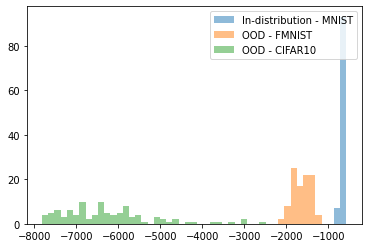

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


ll_indist = -np.load('./array/indist_nll.npy')
ll_ood_fash = -np.load('./array/ood_fash_nll.npy')
ll_ood_cifar = -np.load('./array/ood_cifar_nll.npy')


min_ll = min(ll_indist.min(), ll_ood_fash.min(), ll_ood_cifar.min())
max_ll = max(ll_indist.max(), ll_ood_fash.max(), ll_ood_cifar.max())
bins_ll = np.linspace(min_ll, max_ll, 50)

plt.hist(ll_indist, bins_ll, alpha=0.5, label='In-distribution - MNIST')
plt.hist(ll_ood_fash, bins_ll, alpha=0.5, label='OOD - FMNIST')
plt.hist(ll_ood_cifar, bins_ll, alpha=0.5, label='OOD - CIFAR10')

plt.legend(loc='upper right')
plt.show()

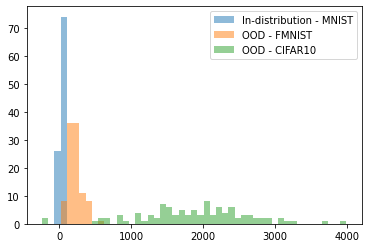

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


regret_indist = np.load('./array/indist_regret.npy')
regret_ood_fash = np.load('./array/ood_fash_regret.npy')
regret_ood_cifar = np.load('./array/ood_cifar_regret.npy')


min_ll = min(regret_indist.min(), regret_ood_fash.min(), regret_ood_cifar.min())
max_ll = max(regret_indist.max(), regret_ood_fash.max(), regret_ood_cifar.max())
bins_ll = np.linspace(min_ll, max_ll, 50)

plt.hist(regret_indist, bins_ll, alpha=0.5, label='In-distribution - MNIST')
plt.hist(regret_ood_fash, bins_ll, alpha=0.5, label='OOD - FMNIST')
plt.hist(regret_ood_cifar, bins_ll, alpha=0.5, label='OOD - CIFAR10')

plt.legend(loc='upper right')
plt.show()

#### Plot AUC-ROC

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

### AUC for likelihood regret MNIST VS CIFAR10

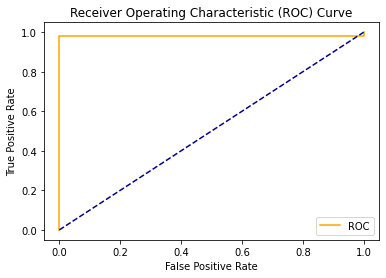

AUC for likelihood regret is:  0.98


In [ ]:
from sklearn import metrics

regret_indist = np.load('./array/indist_regret.npy')
regret_ood_cifar = np.load('./array/ood_cifar_regret.npy')

combined = np.concatenate((regret_indist, regret_ood_cifar))
label_1 = np.ones(len(regret_indist))
label_2 = np.zeros(len(regret_ood_cifar))
label = np.concatenate((label_1, label_2))

fpr, tpr, thresholds = metrics.roc_curve(label, combined, pos_label=0)

plot_roc_curve(fpr, tpr)

rocauc = metrics.auc(fpr, tpr)
print('AUC for likelihood regret is: ', rocauc)

### AUC for likelihood regret MNIST VS FASHION MNIST

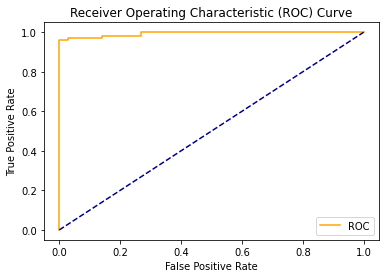

AUC for likelihood regret is:  0.9929


In [ ]:
from sklearn import metrics

regret_indist = np.load('./array/indist_regret.npy')
regret_ood_fash = np.load('./array/ood_fash_regret.npy')

combined = np.concatenate((regret_indist, regret_ood_fash))
label_1 = np.ones(len(regret_indist))
label_2 = np.zeros(len(regret_ood_fash))
label = np.concatenate((label_1, label_2))

fpr, tpr, thresholds = metrics.roc_curve(label, combined, pos_label=0)

plot_roc_curve(fpr, tpr)

rocauc = metrics.auc(fpr, tpr)
print('AUC for likelihood regret is: ', rocauc)

In [ ]:
def likleihood_regret_single(xi, netG, netE):
    NLL_regret_indist = []
    NLL_indist = []
    x = xi.expand(config_model["repeat"],-1,-1,-1).contiguous()
    weights_agg  = []
    with torch.no_grad():
        #NLL ALG.
        for batch_number in range(5):
            
            x = x.to(device)
            b = x.size(0)
    
            [z,mu,logvar] = netE(x)
            recon = netG(z)
            mu = mu.view(mu.size(0),mu.size(1))
            logvar = logvar.view(logvar.size(0), logvar.size(1))
            z = z.view(z.size(0),z.size(1))
            weights = utils.store_NLL(x, recon, mu, logvar, z, config_model["repeat"])
          
            weights_agg.append(weights)
        
        weights_agg = torch.stack(weights_agg).view(-1) 
        
        NLL_loss_before = utils.compute_NLL(weights_agg) 
        NLL_indist = np.append(NLL_indist, NLL_loss_before.detach().cpu().numpy())


                #Likelihood Regret ALG.
    xi = xi.to(device)
    b = xi.size(0)
    netE_copy = copy.deepcopy(netE)
    netE_copy.eval()
    optimizer = optim.Adam(netE_copy.parameters(), lr=config_model["learning_rate"], betas=(config_model["beta-adam"], 0.999),weight_decay=5e-5)
    target = Variable(xi.data.view(-1) * 255).long()
    for it in range(config_model["num_iter_samples"]):
        
        [z,mu,logvar] = netE_copy(xi)
        recon = netG(z)
        
        recon = recon.contiguous()
        recon = recon.view(-1,256)
        recl = loss_fn(recon, target)
        
        recl = torch.sum(recl) / b
        kld = KL_div(mu,logvar)
        
        loss =  recl + kld.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    weights_agg  = []
    with torch.no_grad():
        xi = xi.expand(config_model["repeat"],-1,-1,-1).contiguous()
        target = Variable(xi.data.view(-1) * 255).long()
        for batch_number in range(5):
            [z,mu,logvar] = netE_copy(xi)
            recon = netG(z)
            recon = recon.contiguous()
            mu = mu.view(mu.size(0),mu.size(1))
            logvar = logvar.view(logvar.size(0), logvar.size(1))
            z = z.view(z.size(0),z.size(1))
            weights = utils.store_NLL(x, recon, mu, logvar, z, config_model["repeat"])
            
            weights_agg.append(weights)
     
        
        weights_agg = torch.stack(weights_agg).view(-1) 
        NLL_loss_after = utils.compute_NLL(weights_agg) 
        print('In-dist image OPT: {} VAE: {} diff:{}'.format( NLL_loss_after.item(), NLL_loss_before.item(), NLL_loss_before.item()  - NLL_loss_after.item()))
        regret = NLL_loss_before  - NLL_loss_after
        NLL_regret_indist = np.append(NLL_regret_indist, regret.detach().cpu().numpy())

    return NLL_regret_indist, NLL_indist   

### Implementation of Variational AutoEncoder (VAE)

    * VAE from "Auto-Encoding Variational Bayes" 



In [ ]:
other_config = {
    "batch_size": 100,
    "device": "cuda",
    "learning_rate": 0.001,
    "num_epochs": 30,#30,
    "split_dataset": 0.8,
    "cnn_path":"cnn_models.pt",
    "h-dvae_path":"hdvae_models.pt",
}

In [ ]:
batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset_path = './datasets'

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomRotation(50),
        transforms.Resize((28, 28)),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset_for_vae = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset_for_vae  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader_for_vae = DataLoader(dataset=train_dataset_for_vae, batch_size=batch_size, shuffle=True, **kwargs)
test_loader_for_vae  = DataLoader(dataset=test_dataset_for_vae,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                   
        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function_beta_vae(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def rec_loss(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    return reproduction_loss

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader_for_vae):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function_beta_vae(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  191.3471493830864
	Epoch 2 complete! 	Average Loss:  146.81151181330864
	Epoch 3 complete! 	Average Loss:  132.97187848888774
	Epoch 4 complete! 	Average Loss:  127.83200094232575
	Epoch 5 complete! 	Average Loss:  124.77434837685205
	Epoch 6 complete! 	Average Loss:  122.8943646311561
	Epoch 7 complete! 	Average Loss:  121.50109614657241
	Epoch 8 complete! 	Average Loss:  120.53248707155154
	Epoch 9 complete! 	Average Loss:  119.81402244300396
	Epoch 10 complete! 	Average Loss:  119.29763984896702
	Epoch 11 complete! 	Average Loss:  118.82808215515442
	Epoch 12 complete! 	Average Loss:  118.44507970641173
	Epoch 13 complete! 	Average Loss:  118.06051117096202
	Epoch 14 complete! 	Average Loss:  117.78859644003026
	Epoch 15 complete! 	Average Loss:  117.58848089915485
	Epoch 16 complete! 	Average Loss:  117.26714087280885
	Epoch 17 complete! 	Average Loss:  117.04950591480592
	Epoch 18 complete! 	Average Loss:  116.92402989357262

### Step 5. Generate images from test dataset

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader_for_vae)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


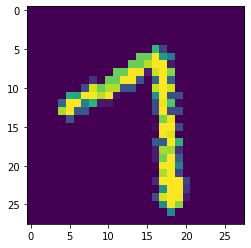

In [ ]:
utils.show_image_28(x, idx=0)

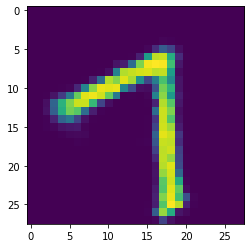

In [ ]:
utils.show_image_28(x_hat, idx=0)

### Step 6. Generate image from noise vector

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = decoder(noise)

In [ ]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample_2.png')

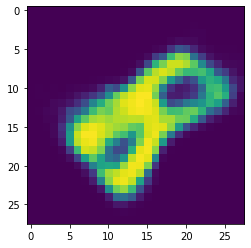

In [ ]:
utils.show_image_28(generated_images, idx=12)

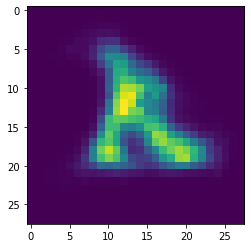

In [ ]:
utils.show_image_28(generated_images, idx=0)

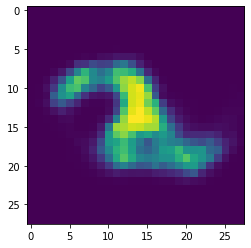

In [ ]:
utils.show_image_28(generated_images, idx=1)

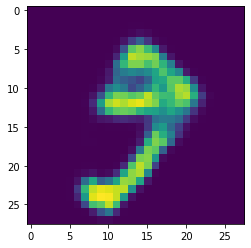

In [ ]:
utils.show_image_28(generated_images, idx=10)

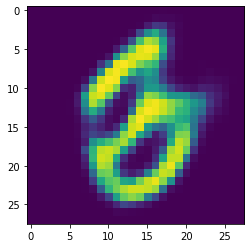

In [ ]:
utils.show_image_28(generated_images, idx=20)

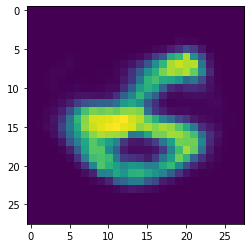

In [ ]:
utils.show_image_28(generated_images, idx=50)

In [54]:
from torchvision.datasets import FashionMNIST

fash_set = FashionMNIST(
    root = './datasets/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
loader_fash = DataLoader(dataset=fash_set, batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/FashionMNIST/raw



In [ ]:
fash_images, _ = next(iter(loader_fash))

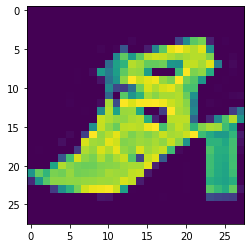

In [ ]:
utils.show_image_28(fash_images, idx=50)

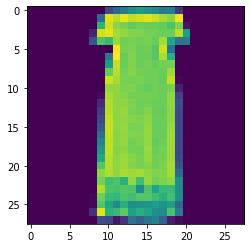

In [ ]:
utils.show_image_28(fash_images, idx=17)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
model.eval()
ood_fashion_loss = np.array([])
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(loader_fash)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
    
        x_hat, mean, log_var = model(x)
        #loss = rec_loss(x, x_hat, mean, log_var)
        for i in np.arange(0,batch_size, 1):
            err = mean_squared_error(x[i].cpu(),x_hat[i].cpu())
            #err = nn.functional.binary_cross_entropy(x_hat[i].cpu(), x[i].cpu(), reduction='sum')
            ood_fashion_loss = np.append(ood_fashion_loss, err)

100%|██████████| 600/600 [00:23<00:00, 25.77it/s]


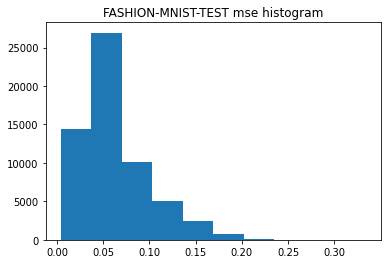

In [ ]:
plt.hist(ood_fashion_loss) 
plt.title("FASHION-MNIST-TEST mse histogram") 
plt.show()

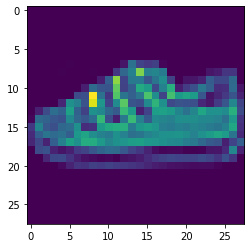

In [ ]:
utils.show_image_28(x, idx=15)

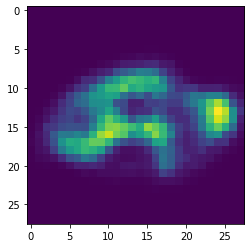

In [ ]:
utils.show_image_28(x_hat, idx=15)

In [ ]:
model.eval()
iod_loss = np.array([])
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader_for_vae)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x_hat, mean, log_var = model(x)
        #loss = rec_loss(x, x_hat, mean, log_var)
        for i in np.arange(0,batch_size, 1):
            err = mean_squared_error(x[i].cpu(),x_hat[i].cpu())
            #err = nn.functional.binary_cross_entropy(x_hat[i].cpu(), x[i].cpu(), reduction='sum')
            iod_loss = np.append(iod_loss, err)

100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


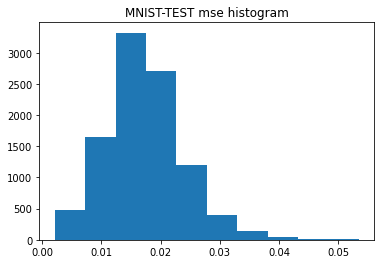

In [ ]:
plt.hist(iod_loss) 
plt.title("MNIST-TEST mse histogram") 
plt.show()

In [43]:
from torchvision.datasets import CIFAR10

cifar_set = CIFAR10(
    root = './datasets/CIFAR10',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor() ,
        transforms.Grayscale(),
		transforms.Resize((28, 28)),
        #transforms.Normalize((0.5,), (0.5,))                            
    ])
)
loader_cifar = DataLoader(dataset=cifar_set, batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/CIFAR10/cifar-10-python.tar.gz to ./datasets/CIFAR10


In [ ]:
cifar_images, _ = next(iter(loader_cifar))

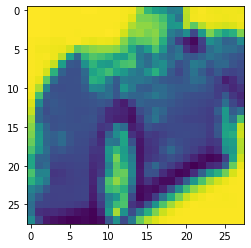

In [ ]:
utils.show_image_28(cifar_images, idx=50)

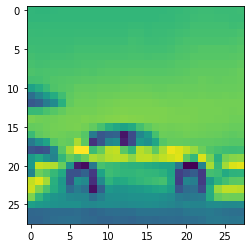

In [ ]:
utils.show_image_28(cifar_images, idx=20)

In [ ]:
model.eval()
ood_cifar_loss = np.array([])
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(loader_cifar)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
    
        x_hat, mean, log_var = model(x)
        #loss = rec_loss(x, x_hat, mean, log_var)
        for i in np.arange(0,batch_size, 1):
            err = mean_squared_error(x[i].cpu(),x_hat[i].cpu())
            #err = nn.functional.binary_cross_entropy(x_hat[i].cpu(), x[i].cpu(), reduction='sum')
            ood_cifar_loss = np.append(ood_cifar_loss, err)

100%|██████████| 500/500 [00:19<00:00, 25.99it/s]


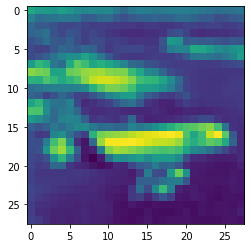

In [ ]:
utils.show_image_28(x, idx=10)

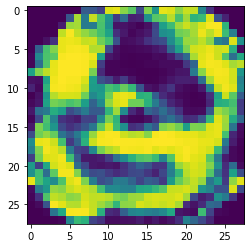

In [ ]:
utils.show_image_28(x_hat, idx=10)

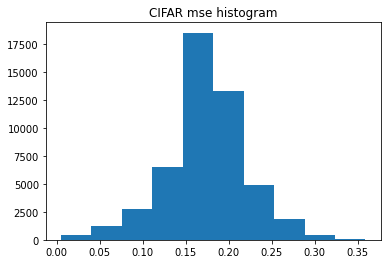

In [ ]:
plt.hist(ood_cifar_loss) 
plt.title("CIFAR mse histogram") 
plt.show()

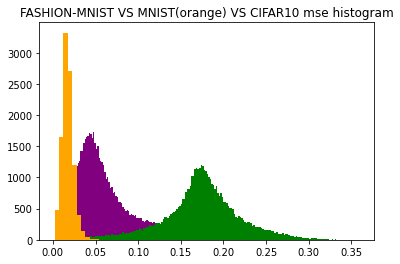

In [ ]:
plt.hist(ood_fashion_loss, bins= 200, color="purple")
plt.hist(ood_cifar_loss, bins= 200, color="green")
plt.hist(iod_loss, color="orange") 
plt.title("FASHION-MNIST VS MNIST(orange) VS CIFAR10 mse histogram") 
plt.show()

In [ ]:
sorted(iod_loss, reverse=True)
min(ood_fashion_loss)

0.0042302049696445465

### Save Model

In [ ]:
torch.save(copy.deepcopy(model), "beta_vae.pt")

### CNN Model

In [ ]:
class cnn(nn.Module):
    def __init__(self, input_layer, kernel_size, output_layer):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, output_layer)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output   

In [ ]:
criterion = nn.CrossEntropyLoss()
def train_model(model, trainloader, optimizer, num_epochs = 30, is_cnn = False):
  train_loss_arr = np.zeros(num_epochs)
  valid_loss_arr = np.zeros(num_epochs)
  train_acc_arr = np.zeros(num_epochs)
  valid_acc_arr = np.zeros(num_epochs)
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      

      # Each epoch has a training and validation phase
    for phase in ['train']:
      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mod 


      epoch_loss = 0.0
      running_loss = 0.0
      valid_loss = 0.0 
      train_running_corrects = 0.0
      valid_running_corrects = 0.0
      train_total = 0
      val_total = 0
      for i, data in enumerate(trainloader[phase], 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          if is_cnn == False:
            inputs = inputs.view(inputs.shape[0], -1)
          # mode to device/cuda
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == 'train'):
              target = model(inputs)
              _, preds = torch.max(target, 1)
              loss = criterion(target, labels)
              if phase == 'train':
                loss.backward()
                optimizer.step()

          if phase == 'val':
            valid_loss += loss.item()# * inputs.size(0)
            val_total += labels.size(0)
            valid_running_corrects += (preds == labels).sum().item() 
          # print statistics
          if phase == 'train':
              train_total += labels.size(0)
              train_running_corrects += (preds == labels).sum().item()   
              running_loss += loss.item()
              epoch_loss += loss.item()
              if i % 100 == 1:    # print every 100 mini-batches
                print('epoch: %2d, minibatch: %2d, loss: %.3f' %
                    (epoch + 1, i / 100, running_loss / 100))
                running_loss = 0.0
      if phase == 'train':
        train_loss_arr[epoch] = epoch_loss/len(trainloader[phase])
        train_acc_arr[epoch] = 100*(train_running_corrects / train_total)
      else:
        valid_loss_arr[epoch] = valid_loss/len(trainloader[phase])
        valid_acc_arr[epoch] = 100*(valid_running_corrects / val_total)
  print('Finished Training')
  return model, train_loss_arr, valid_loss_arr, train_acc_arr, valid_acc_arr

In [ ]:
mnist_data_loader = {
    "train":  train_loader_for_vae,
    "test": test_loader_for_vae,
}

In [ ]:
kernel_size = 5
input_layer = 784
output_layer = 10
cnn_model = cnn(input_layer, kernel_size, output_layer).to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=other_config["learning_rate"])  
cnn_model, *_ = train_model(cnn_model, mnist_data_loader, optimizer,other_config["num_epochs"], True)

epoch:  1, minibatch:  0, loss: 0.046
epoch:  1, minibatch:  1, loss: 1.080
epoch:  1, minibatch:  2, loss: 0.400
epoch:  1, minibatch:  3, loss: 0.285
epoch:  1, minibatch:  4, loss: 0.242
epoch:  1, minibatch:  5, loss: 0.210
epoch:  2, minibatch:  0, loss: 0.003
epoch:  2, minibatch:  1, loss: 0.174
epoch:  2, minibatch:  2, loss: 0.162
epoch:  2, minibatch:  3, loss: 0.163
epoch:  2, minibatch:  4, loss: 0.149
epoch:  2, minibatch:  5, loss: 0.144
epoch:  3, minibatch:  0, loss: 0.002
epoch:  3, minibatch:  1, loss: 0.133
epoch:  3, minibatch:  2, loss: 0.137
epoch:  3, minibatch:  3, loss: 0.117
epoch:  3, minibatch:  4, loss: 0.120
epoch:  3, minibatch:  5, loss: 0.107
epoch:  4, minibatch:  0, loss: 0.004
epoch:  4, minibatch:  1, loss: 0.110
epoch:  4, minibatch:  2, loss: 0.110
epoch:  4, minibatch:  3, loss: 0.104
epoch:  4, minibatch:  4, loss: 0.104
epoch:  4, minibatch:  5, loss: 0.090
epoch:  5, minibatch:  0, loss: 0.001
epoch:  5, minibatch:  1, loss: 0.087
epoch:  5, m

In [ ]:
def cnn_acc(model, data_iter):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_iter:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network: {} %'.format(100 * correct / total))
    return correct / total

In [ ]:
cnn_acc(cnn_model, mnist_data_loader["test"])

Accuracy of the network: 98.56 %


0.9856

### Save Model

In [ ]:
torch.save(copy.deepcopy(cnn_model), "cnn_model.pt")

## Test Section - Start Here

In [1]:
# clone the github repository to access source code
!git clone https://github.com/AvihaiNaa/gmdl_final.git

# set the correct directory
%cd gmdl_final

Cloning into 'gmdl_final'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 2), reused 21 (delta 2), pack-reused 0
Unpacking objects: 100% (21/21), done.
/content/gmdl_final


In [2]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch.nn.functional as F
import gmdl_final.utils as utils
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import torch.optim as optim
from torch.autograd import Variable
import os
import copy

In [3]:
dataset_path = './datasets'
config = {
    "batch_size": 100,
    "device": "cuda",
    "learning_rate": 0.001,
    "num_epochs": 30,#30,
    "split_dataset": 0.8,
    "cnn_path":"cnn_models.pt",
    "h-dvae_path":"hdvae_models.pt",
    #"image_size": (28, 28)
    "image_size": (32, 32),
    "experiment": 'models/mnist'
}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(config["image_size"]),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomRotation(50),
        #AddGaussianNoise(0.1, 0.08),
        transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
        transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.5, 1))
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=config["batch_size"], shuffle=False, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [5]:
import gmdl_final.model as DVAE

In [6]:
config_model ={
    "beta-vae": 1.,
    "beta-adam": 0.9,
    "number_gpu": 1,
    "latent_z_vector": 100,
    "input_image_channels": 1,
    "hidden_channel_size": 32,
    #"image_size": 28,
    "image_size": 32,
    "learning_rate": 3e-4,
    "learning_rate_regret": 2e-4,
    "epochs": 1,#30,
    "perturbed": False,
    "ratio": 0.2,
    "dataroot": './data',
    "repeat":100,
    "num_iter_samples": 100    
}

In [7]:
loss_fn = nn.CrossEntropyLoss(reduction = 'none')

In [8]:
def loss_function(x_src, recon, target, mean, log_var):
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    b = x_src.size(0)
    recl = loss_fn(recon, target)
    recl = torch.sum(recl) / b
    kld = KL_div(mean, log_var)
    return recl + config_model["beta-vae"] * kld.mean(), recl, kld


def KL_div(mu, logvar, reduction='avg'):
    mu = mu.view(mu.size(0), mu.size(1))
    logvar = logvar.view(logvar.size(0), logvar.size(1))
    if reduction == 'sum':
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    else:
        KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1)
        return KL

In [9]:
def likleihood_regret_single(xi, netG, netE):
    netG.eval()
    netE.eval()
    loss_fn = nn.CrossEntropyLoss(reduction = 'none')
    NLL_regret_indist = []
    NLL_indist = []
    x = xi.expand(config_model["repeat"],-1,-1,-1).contiguous()
    weights_agg  = []
    with torch.no_grad():
        #NLL ALG.
        for batch_number in range(5):
            
            x = x.to(device)
            b = x.size(0)
    
            [z,mu,logvar] = netE(x)
            recon = netG(z)
            mu = mu.view(mu.size(0),mu.size(1))
            logvar = logvar.view(logvar.size(0), logvar.size(1))
            z = z.view(z.size(0),z.size(1))
            weights = utils.store_NLL(x, recon, mu, logvar, z, config_model["repeat"])
          
            weights_agg.append(weights)
        
        weights_agg = torch.stack(weights_agg).view(-1) 
        
        NLL_loss_before = utils.compute_NLL(weights_agg) 
        NLL_indist = np.append(NLL_indist, NLL_loss_before.detach().cpu().numpy())


                #Likelihood Regret ALG.
    xi = xi.to(device)
    b = xi.size(0)
    netE_copy = copy.deepcopy(netE)
    netE_copy.eval()
    optimizer = optim.Adam(netE_copy.parameters(), lr=config_model["learning_rate"], betas=(config_model["beta-adam"], 0.999),weight_decay=5e-5)
    target = Variable(xi.data.view(-1) * 255).long()
    for it in range(config_model["num_iter_samples"]):
        
        [z,mu,logvar] = netE_copy(xi)
        recon = netG(z)
        
        recon = recon.contiguous()
        recon = recon.view(-1,256)
        recl = loss_fn(recon, target)
        
        recl = torch.sum(recl) / b
        kld = KL_div(mu,logvar)
        
        loss =  recl + kld.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    weights_agg  = []
    with torch.no_grad():
        xi = xi.expand(config_model["repeat"],-1,-1,-1).contiguous()
        target = Variable(xi.data.view(-1) * 255).long()
        for batch_number in range(5):
            [z,mu,logvar] = netE_copy(xi)
            recon = netG(z)
            recon = recon.contiguous()
            mu = mu.view(mu.size(0),mu.size(1))
            logvar = logvar.view(logvar.size(0), logvar.size(1))
            z = z.view(z.size(0),z.size(1))
            weights = utils.store_NLL(x, recon, mu, logvar, z, config_model["repeat"])
            
            weights_agg.append(weights)
     
        
        weights_agg = torch.stack(weights_agg).view(-1) 
        NLL_loss_after = utils.compute_NLL(weights_agg) 
        print('In-dist image OPT: {} VAE: {} diff:{}'.format(NLL_loss_after.item(), NLL_loss_before.item(), NLL_loss_before.item()  - NLL_loss_after.item()))
        regret = NLL_loss_before  - NLL_loss_after
        NLL_regret_indist = np.append(NLL_regret_indist, regret.detach().cpu().numpy())

    return NLL_regret_indist, NLL_indist   

In [10]:
other_config = {
    "batch_size": 100,
    "device": "cuda",
    "learning_rate": 0.001,
    "num_epochs": 30,#30,
    "split_dataset": 0.8,
    "cnn_path":"cnn_models.pt",
    "h-dvae_path":"hdvae_models.pt",
}

In [11]:
batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs =  30

In [12]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset_path = './datasets'

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomRotation(50),
        transforms.Resize((28, 28)),
        #transforms.Resize((32, 32)),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset_for_vae = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset_for_vae  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader_for_vae = DataLoader(dataset=train_dataset_for_vae, batch_size=batch_size, shuffle=True, **kwargs)
test_loader_for_vae  = DataLoader(dataset=test_dataset_for_vae,  batch_size=batch_size, shuffle=False, **kwargs)

In [13]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                   
        return mean, log_var

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [15]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [16]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [17]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function_beta_vae(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def rec_loss(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    return reproduction_loss

optimizer = Adam(model.parameters(), lr=lr)

In [18]:
class cnn(nn.Module):
    def __init__(self, input_layer, kernel_size, output_layer):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, output_layer)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output   

In [19]:
mnist_data_loader = {
    "train":  train_loader_for_vae,
    "test": test_loader_for_vae,
}

In [20]:
kernel_size = 5
input_layer = 784
output_layer = 10

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [23]:
import gmdl_final.loader as loader
fmnist_data_loader = loader.load_fmnist(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])
cifar_data_loader = loader.load_cifar(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])
svhn_data_loader = loader.load_svhn(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])
emnist_letters_data_loader = loader.load_emnist_letters(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])
mnist_test_data_loader = loader.load_mnist_test(config_model["dataroot"], config["image_size"], config["batch_size"], kwargs['num_workers'])

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


  0%|          | 0/64275384 [00:00<?, ?it/s]

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### OSR ALGORITHM

OSR ALG
calc liklihoodregret
calc mse
is ood -> unkown
is not ood -> cnn -> classify

In [24]:
x_dim  = 784
hidden_dim = 400
latent_dim = 200

def load_model_dcgan():
    netG = DVAE.DCGAN_G(config_model["image_size"], config_model["latent_z_vector"], config_model["input_image_channels"],config_model["hidden_channel_size"],  config_model["number_gpu"])
    state_G = torch.load('./saved_models/models/mnist/netG_pixel.pth', map_location = device)
    netG.load_state_dict(state_G)
    netG.to(device)
    return netG.eval()

def load_model_vae():
    netE = DVAE.Encoder(config_model["image_size"], config_model["latent_z_vector"], config_model["input_image_channels"],config_model["hidden_channel_size"],  config_model["number_gpu"])
    state_E = torch.load('./saved_models/models/mnist/netE_pixel.pth', map_location = device)
    netE.load_state_dict(state_E)
    netE.to(device)
    return netE.eval()

def load_beta_vae():
    encoder = Encoder(x_dim, hidden_dim, latent_dim)
    decoder = Decoder(latent_dim, hidden_dim, x_dim)
    beta_vae = Model(encoder, decoder)
    state_E = torch.load('./beta_vae.pt')
    beta_vae.load_state_dict(torch.load('./beta_vae.pt'))
    beta_vae.to(device)
    return beta_vae.eval()

def load_model_cnn():
    cnn_class = cnn(input_layer, kernel_size, output_layer)
    cnn_class.load_state_dict(torch.load('./cnn_model.pt'))
    cnn_class.to(device)
    return cnn_class.eval()


In [25]:
def mse_via_vae_beta(xi, vae_b, batch_size, x_dim):
    vae_b.eval()
    mse_res = np.array([])
    with torch.no_grad():
            x = xi.view(batch_size, x_dim)
            x = x.to(device)
            x_hat, mean, log_var = vae_b(x)
            for i in np.arange(0,batch_size, 1):
                err = mean_squared_error(x[i].cpu(),x_hat[i].cpu())
                #err = nn.functional.binary_cross_entropy(x_hat[i].cpu(), x[i].cpu(), reduction='sum')
                mse_res = np.append(mse_res, err)
    return mse_res

In [26]:
def OSR(dataloader, ood = False, limited = False):
    classifier = np.array([])
    dataset_labels = np.array([])
    netG = load_model_dcgan()
    netE = load_model_vae()
    beta_vae =  load_beta_vae()

    cnn_model = load_model_cnn()
    threshold_reg = 75
    threshold_mse = 0.05
    correct = 0
    total = 0
    j = 0
    img_size = 28
    unknowm_cnt = 0
    for images, labels in dataloader:
        if transforms.functional.get_image_size(images)[0] == img_size:
           threshold_reg = 87
        j = j + 1
        out = F.interpolate(images, size=(28, 28), mode='bilinear')  
        lik_inp = F.interpolate(images, size=(32, 32), mode='bilinear')  
        likleli_regret, l2 = likleihood_regret_single(lik_inp, netG, netE)
        #utils.show_image_28(out, idx = 31)
        mse_ = mse_via_vae_beta(out, beta_vae, 100, 784)
        if likleli_regret > threshold_reg and mse_.all() > threshold_mse:
                classifier = np.append(classifier, np.ones(len(images)) * 10)
                if ood:
                    dataset_labels = np.append(dataset_labels, np.ones(len(images)) * 10)
                else:
                    dataset_labels = np.append(dataset_labels, labels.cpu())
                unknowm_cnt += 1
        else:
            with torch.no_grad():                
                images = out.to(device)
                labels = labels.to(device)
                outputs = cnn_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                classifier = np.append(classifier, predicted.cpu())
                dataset_labels = np.append(dataset_labels, labels.cpu())
        if j == 15 and limited == True:
            break
    if total > 0:
        print('Accuracy of the network(known): {} %'.format(100 * correct / total))
        
    return classifier, dataset_labels, correct, total, unknowm_cnt, len(dataloader)

## Computer Exercise 1

In [27]:
iod_classifier, iod_true, correct, total, unknowm_cnt, len_data = OSR(test_loader, False)

In-dist image OPT: 717.8999633789062 VAE: 728.8864135742188 diff:10.9864501953125
In-dist image OPT: 674.0372314453125 VAE: 688.6641235351562 diff:14.62689208984375
In-dist image OPT: 642.8595581054688 VAE: 653.1843872070312 diff:10.3248291015625
In-dist image OPT: 650.4967041015625 VAE: 660.20361328125 diff:9.7069091796875
In-dist image OPT: 659.96044921875 VAE: 662.869384765625 diff:2.908935546875
In-dist image OPT: 629.3888549804688 VAE: 622.6128540039062 diff:-6.7760009765625
In-dist image OPT: 732.6654663085938 VAE: 734.9090576171875 diff:2.24359130859375
In-dist image OPT: 689.1575927734375 VAE: 705.2604370117188 diff:16.10284423828125
In-dist image OPT: 686.1478271484375 VAE: 734.00537109375 diff:47.8575439453125
In-dist image OPT: 577.2776489257812 VAE: 580.1489868164062 diff:2.871337890625
In-dist image OPT: 705.298095703125 VAE: 719.5225219726562 diff:14.22442626953125
In-dist image OPT: 703.9188232421875 VAE: 731.02099609375 diff:27.1021728515625
In-dist image OPT: 697.55462

## Computer Exercise 2

In [28]:
ood_classifier, ood_true, correct, total, unknowm_cnt, len_data = OSR(cifar_data_loader, True, True)

In-dist image OPT: 5011.2470703125 VAE: 6667.6103515625 diff:1656.36328125
In-dist image OPT: 3749.927978515625 VAE: 4547.43017578125 diff:797.502197265625
In-dist image OPT: 3322.9375 VAE: 7628.87353515625 diff:4305.93603515625
In-dist image OPT: 1966.989013671875 VAE: 2531.0107421875 diff:564.021728515625
In-dist image OPT: 3610.715087890625 VAE: 5201.56396484375 diff:1590.848876953125
In-dist image OPT: 3809.38330078125 VAE: 7973.09228515625 diff:4163.708984375
In-dist image OPT: 4259.59228515625 VAE: 6849.7705078125 diff:2590.17822265625
In-dist image OPT: 5087.30126953125 VAE: 7512.5751953125 diff:2425.27392578125
In-dist image OPT: 4867.12451171875 VAE: 6635.849609375 diff:1768.72509765625
In-dist image OPT: 5597.34765625 VAE: 8945.96484375 diff:3348.6171875
In-dist image OPT: 4959.81640625 VAE: 8752.1806640625 diff:3792.3642578125
In-dist image OPT: 5450.5 VAE: 8928.482421875 diff:3477.982421875
In-dist image OPT: 4950.2119140625 VAE: 6615.82958984375 diff:1665.61767578125
In-di

## Evaluation

#### Baseline Accuracy - MNIST

In [29]:
correct = (iod_classifier == iod_true).sum().item()
correct / len(iod_classifier)

0.9677

#### Baseline Accuracy - CIFAR 10

In [30]:
correct = (ood_classifier == ood_true).sum().item()
correct / len(ood_classifier)

1.0

#### Confusion Matrix

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
confusion_matrix(iod_true, iod_classifier)

array([[ 972,    0,    0,    0,    0,    1,    5,    1,    1,    0],
       [   1, 1121,    1,    3,    0,    2,    3,    2,    2,    0],
       [   0,    3, 1018,    0,    2,    0,    1,    5,    3,    0],
       [   1,    0,    2,  981,    0,   15,    0,    5,    2,    4],
       [   1,    4,   11,    0,  887,    0,   16,    9,    6,   48],
       [   2,    0,    1,    2,    0,  863,   17,    2,    1,    4],
       [   6,    2,    0,    0,    1,    6,  942,    0,    0,    1],
       [   0,    6,   27,    1,    3,    0,    0,  988,    0,    3],
       [  13,    0,    8,    3,    2,    5,   18,    1,  920,    4],
       [   3,    2,    2,    1,    2,    6,    0,    5,    3,  985]])

In [33]:
temp_iod_true = iod_true
temp_iod_classifier = iod_classifier

temp_ood_true = ood_true
temp_ood_classifier = ood_classifier

temp_iod_true[temp_iod_true < 10] = 0
temp_iod_classifier[temp_iod_classifier < 10] = 0

temp_ood_true[temp_ood_true < 10] = 0
temp_ood_classifier[temp_ood_classifier < 10] = 0

In [34]:
from sklearn.metrics import accuracy_score
all_true = np.concatenate((temp_iod_true, temp_ood_true), axis=0)
all_preds = np.concatenate((temp_iod_classifier, temp_ood_classifier), axis=0)


accuracy_score(all_true, all_preds)


1.0

In [35]:
confusion_matrix(all_true, all_preds)

array([[10000,     0],
       [    0,  1500]])

In [36]:
all_true_multi = np.concatenate((iod_true, ood_true), axis=0)
all_preds_multi = np.concatenate((iod_classifier, ood_classifier), axis=0)

confusion_matrix(all_true_multi, all_preds_multi)

array([[10000,     0],
       [    0,  1500]])